# Análise das candidaturas a vereador nas eleições de 2020 na Bahia

### - Dados

As candidaturas possuem até o dia 15 de Dezembro para declarar suas contas.

Os dados utilizados nesta análise podem ser baixados no site do [Tribunal Superior Eleitoral (TSE)](https://www.tse.jus.br/eleicoes/estatisticas/repositorio-de-dados-eleitorais-1/repositorio-de-dados-eleitorais).

Baixe o arquivo: http://agencia.tse.jus.br/estatistica/sead/odsele/prestacao_contas/prestacao_de_contas_eleitorais_candidatos_2020.zip (downloaded in 22/12/2020)

Na mesma pasta deste notebook, crie uma pasta chamada data.

Em seguida, mova a pasta `prestacao_de_contas_eleitorais_candidatos_2020`
(extraída do arquivo), para a pasta data.

Dicionario de dados: `leiame_receitas-candidatos.pdf`

### - Perguntas

Algumas perguntas surgem deste dataset:

- Para um dado município, quem são os atores mais importantes?
- Como são as candidaturas na Bahia?
- Quem são as pessoas físicas doadoras?
- Quais são os gastos da campanha?
- Quais as empresas mais beneficiadas?


### Entrevistar vereadores:

- Parabéns pela eleição etc
- De onde veio o dinheiro? Por que o partido resolveu apoiar você e não outros?
- Quais são os principais gastos da campanha?
- Sua campanha custou X para os cidadãos. Daria pra comprar Y cestas básicas. Qual o saldo que você espera devolver pros cidadãos ao longo dos 4 anos de mandato?

### ETL

A seguir a etapa de extração, transformação e load (carregamento) dos dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scripts.parsers import currency_to_float

%matplotlib notebook

[nltk_data] Downloading package stopwords to /home/guiga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def format_float(num):
    num = round(num, 2)
    num = str(num)
    num = num.replace(".", ",")

    dot_index = abs(num.index(",") - len(num))
    dots = [i for i in range(dot_index+2,len(num)-1,3)]
    
    str_num = []
    if dot_index < 3:
        str_num.append("0")
    for i, digit in enumerate(num[::-1]):
        str_num.insert(0, digit)
        if i in dots:
            str_num.insert(0, ".")
    return "".join(str_num)

def format_int(num):
    num = str(num)
    str_num = []
    for i, digit in enumerate(num[::-1]):
        if (i>0) and (i % 3 == 0):
            str_num.insert(0, ".")
        str_num.insert(0, digit)
    return "".join(str_num)

def format_num(num):
    if isinstance(num, int):
        return format_int(num)
    if isinstance(num, float):
        return format_float(num)
    raise KeyError(f"{type(num)} is not a supported number format")

### Preparação dos dados

In [3]:
state = 'BA'
folder = "data/"
persistence_folder = "textos/candidaturas_bahia/analise_vereadores/"

In [4]:
path = f"{folder}votacao_candidato_munzona_2020/votacao_candidato_munzona_2020_{state}.csv"
results = pd.read_csv(path, encoding="latin", delimiter=";")

In [5]:
columns = ["SQ_CANDIDATO",
           "NM_CANDIDATO",
           "NM_URNA_CANDIDATO",
           "NM_UE",
           "SG_PARTIDO",
           "DS_SIT_TOT_TURNO",
           "QT_VOTOS_NOMINAIS",
           "DS_CARGO"
]
results = results[columns]

In [6]:
columns.remove("QT_VOTOS_NOMINAIS")
results = results.groupby(columns).agg({"QT_VOTOS_NOMINAIS": sum})
results = results.reset_index()
results.sample(5).T

,7684,4182,3472,13726,13259
SQ_CANDIDATO,50000738793,50000691073,50000675791,50000857469,50000844527
NM_CANDIDATO,IDEVALDO SANTOS SAMPAIO,JOCNEÃ PEREIRA COTIA LISBOA,AGNALDO CORTEZ CARDOSO,ROSEMARE NUNES ALMEIDA,ANDRÉ SILVA BISPO
NM_URNA_CANDIDATO,IDEVALDO SAMPAIO MELA,JOCNEÃ,NALDO,MEIRE NUNES,ANDRÉ DO ROÇADINHO
NM_UE,NOVA IBIÁ,CANAVIEIRAS,RIACHÃO DAS NEVES,ITIRUÇU,SERROLÂNDIA
SG_PARTIDO,PP,PV,PP,PSB,PP
DS_SIT_TOT_TURNO,SUPLENTE,NÃO ELEITO,SUPLENTE,SUPLENTE,NÃO ELEITO
DS_CARGO,Vereador,Vereador,Vereador,Vereador,Vereador
QT_VOTOS_NOMINAIS,55,22,59,8,78


In [7]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37213 entries, 0 to 37212
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SQ_CANDIDATO       37213 non-null  int64 
 1   NM_CANDIDATO       37213 non-null  object
 2   NM_URNA_CANDIDATO  37213 non-null  object
 3   NM_UE              37213 non-null  object
 4   SG_PARTIDO         37213 non-null  object
 5   DS_SIT_TOT_TURNO   37213 non-null  object
 6   DS_CARGO           37213 non-null  object
 7   QT_VOTOS_NOMINAIS  37213 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 2.3+ MB


In [8]:
candidates_count = len(results)
print(f"{format_num(candidates_count)} resultados para candidatos na base de dados")

37.213 resultados para candidatos na base de dados


No [site do TSE](https://www.tse.jus.br/eleicoes/estatisticas/estatisticas-eleitorais) constam 37.261 candidaturas aptas a vereador

In [9]:
path = f"{folder}prestacao_de_contas_eleitorais_candidatos_2020/despesas_contratadas_candidatos_2020_{state}.csv"
expendings_df = pd.read_csv(path, encoding="latin", delimiter=";")
expendings_df["VR_DESPESA_CONTRATADA"] = expendings_df["VR_DESPESA_CONTRATADA"].apply(currency_to_float)
expendings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201059 entries, 0 to 201058
Data columns (total 53 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   DT_GERACAO                 201059 non-null  object 
 1   HH_GERACAO                 201059 non-null  object 
 2   ANO_ELEICAO                201059 non-null  int64  
 3   CD_TIPO_ELEICAO            201059 non-null  int64  
 4   NM_TIPO_ELEICAO            201059 non-null  object 
 5   CD_ELEICAO                 201059 non-null  int64  
 6   DS_ELEICAO                 201059 non-null  object 
 7   DT_ELEICAO                 201059 non-null  object 
 8   ST_TURNO                   201059 non-null  int64  
 9   TP_PRESTACAO_CONTAS        201059 non-null  object 
 10  DT_PRESTACAO_CONTAS        201059 non-null  object 
 11  SQ_PRESTADOR_CONTAS        201059 non-null  int64  
 12  SG_UF                      201059 non-null  object 
 13  SG_UE                      20

In [10]:
columns = ["SQ_CANDIDATO", "DS_ORIGEM_DESPESA", "VR_DESPESA_CONTRATADA"]
expendings_resume = expendings_df[columns]
expendings_resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201059 entries, 0 to 201058
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   SQ_CANDIDATO           201059 non-null  int64  
 1   DS_ORIGEM_DESPESA      201059 non-null  object 
 2   VR_DESPESA_CONTRATADA  201059 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [11]:
# most_expensive_activity = expendings_df.groupby(["SQ_CANDIDATO", "DS_ORIGEM_DESPESA"]).agg(sum)
# most_expensive_activity = most_expensive_activity.sort_values("VR_DESPESA_CONTRATADA", ascending=False)
# most_expensive_activity = most_expensive_activity.reset_index()
# most_expensive_activity = most_expensive_activity.set_index("SQ_CANDIDATO")
# most_expensive_activity = most_expensive_activity.max(axis=1, level=0, numeric_only=True)
# most_expensive_activity
# most_expensive_activity["VR_DESPESA_CONTRATADA"].idxmax(axis=1, level=0)
# most_expensive_activity.head(10)

In [12]:
# TODO: mudar a despesa da moda para a despesa com mais gasto

expendings_gp = (expendings_resume.groupby(["SQ_CANDIDATO"])
                 .agg({"VR_DESPESA_CONTRATADA": sum, 
                       "DS_ORIGEM_DESPESA": pd.Series.mode})
                 .sort_values("VR_DESPESA_CONTRATADA", ascending=False))
expendings_gp = expendings_gp.reset_index()
expendings_gp.head()

,SQ_CANDIDATO,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA
0,50000674223,12296492.55,Serviços prestados por terceiros
1,50000708248,3415293.83,"Encargos financeiros, taxas bancárias e/ou op...."
2,50000913695,2719545.00,"Encargos financeiros, taxas bancárias e/ou op...."
3,50000758814,2497994.59,Publicidade por materiais impressos
4,50000824378,2435678.10,"Encargos financeiros, taxas bancárias e/ou op...."


In [13]:
expendings_gp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21970 entries, 0 to 21969
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SQ_CANDIDATO           21970 non-null  int64  
 1   VR_DESPESA_CONTRATADA  21970 non-null  float64
 2   DS_ORIGEM_DESPESA      21970 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 515.0+ KB


In [14]:
results = results.merge(expendings_gp, how="left", on="SQ_CANDIDATO")

In [15]:
results["DS_ORIGEM_DESPESA"] = results["DS_ORIGEM_DESPESA"].fillna("SEM DESPESA")
results["VR_DESPESA_CONTRATADA"] = results["VR_DESPESA_CONTRATADA"].fillna(0)

In [16]:
path = f"{folder}prestacao_de_contas_eleitorais_candidatos_2020/receitas_candidatos_2020_{state}.csv"
earnings = pd.read_csv(path, encoding="latin", delimiter=";")
earnings["VR_RECEITA"] = earnings["VR_RECEITA"].apply(currency_to_float)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115420 entries, 0 to 115419
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DT_GERACAO                   115420 non-null  object 
 1   HH_GERACAO                   115420 non-null  object 
 2   ANO_ELEICAO                  115420 non-null  int64  
 3   CD_TIPO_ELEICAO              115420 non-null  int64  
 4   NM_TIPO_ELEICAO              115420 non-null  object 
 5   CD_ELEICAO                   115420 non-null  int64  
 6   DS_ELEICAO                   115420 non-null  object 
 7   DT_ELEICAO                   115420 non-null  object 
 8   ST_TURNO                     115420 non-null  int64  
 9   TP_PRESTACAO_CONTAS          115420 non-null  object 
 10  DT_PRESTACAO_CONTAS          115420 non-null  object 
 11  SQ_PRESTADOR_CONTAS          115420 non-null  int64  
 12  SG_UF                        115420 non-null  object 
 13 

In [17]:
columns = ["SQ_CANDIDATO", "DS_RECEITA", "VR_RECEITA"]
earnings_resume = earnings[columns]

In [18]:
# TODO: Change pd.Series.mode to biggest money source
earnings_resume = earnings_resume.groupby("SQ_CANDIDATO").agg({"VR_RECEITA": sum, "DS_RECEITA": pd.Series.mode})

In [19]:
results = results.merge(earnings_resume, on="SQ_CANDIDATO", how="left")
results["VR_RECEITA"] = results["VR_RECEITA"].fillna(0)
results["DS_RECEITA"] = results["DS_RECEITA"].fillna("SEM RECEITA")
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37213 entries, 0 to 37212
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SQ_CANDIDATO           37213 non-null  int64  
 1   NM_CANDIDATO           37213 non-null  object 
 2   NM_URNA_CANDIDATO      37213 non-null  object 
 3   NM_UE                  37213 non-null  object 
 4   SG_PARTIDO             37213 non-null  object 
 5   DS_SIT_TOT_TURNO       37213 non-null  object 
 6   DS_CARGO               37213 non-null  object 
 7   QT_VOTOS_NOMINAIS      37213 non-null  int64  
 8   VR_DESPESA_CONTRATADA  37213 non-null  float64
 9   DS_ORIGEM_DESPESA      37213 non-null  object 
 10  VR_RECEITA             37213 non-null  float64
 11  DS_RECEITA             37213 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 3.7+ MB


In [20]:
results.head().T

,0,1,2,3,4
SQ_CANDIDATO,50000631822,50000631823,50000631824,50000631825,50000631826
NM_CANDIDATO,TIAGO PRATES MACHADO,SELMA DE JESUS SANTOS,VANIA LUCIA PEREIRA DE ALMEIDA,FABIO COSTA DOS SANTOS,SHIRLEY VITAL DE JESUS
NM_URNA_CANDIDATO,TIAGO PRATES,SELMA DE DICA,NINHA DE DERCILIO,FABIO DO PORTELA,SHIRLEY VITAL
NM_UE,IBIRAPUÃ,IBIRAPUÃ,IBIRAPUÃ,IBIRAPUÃ,IBIRAPUÃ
SG_PARTIDO,PT,PT,PT,PT,PT
DS_SIT_TOT_TURNO,NÃO ELEITO,NÃO ELEITO,NÃO ELEITO,NÃO ELEITO,NÃO ELEITO
DS_CARGO,Vereador,Vereador,Vereador,Vereador,Vereador
QT_VOTOS_NOMINAIS,34,16,11,10,19
VR_DESPESA_CONTRATADA,2050,1550,0,1850,2150
DS_ORIGEM_DESPESA,Atividades de militância e mobilização de rua,Atividades de militância e mobilização de rua,SEM DESPESA,Atividades de militância e mobilização de rua,Atividades de militância e mobilização de rua


## Comparação entre campanhas de Prefeito e Vereador

In [21]:
candidates_gp = (results[["DS_CARGO", "SQ_CANDIDATO", "VR_RECEITA", "VR_DESPESA_CONTRATADA"]]
                 .groupby("DS_CARGO")
                 .agg({"SQ_CANDIDATO": "nunique", "VR_RECEITA": sum, "VR_DESPESA_CONTRATADA": sum})
)

candidates_gp["VR_NAO_GASTO"] = candidates_gp["VR_RECEITA"] - candidates_gp["VR_DESPESA_CONTRATADA"]
candidates_gp.head()

,SQ_CANDIDATO,VR_RECEITA,VR_DESPESA_CONTRATADA,VR_NAO_GASTO
DS_CARGO,,,,
Prefeito,1256,1.313783e+08,1.247326e+08,6645658.90
Vereador,35953,7.808823e+07,5.502138e+07,23066852.41


In [22]:
def compare_candidatures(df, column):
    total = df[column].sum()
    aldermen = int(df.loc["Vereador", column])
    mayor = int(df.loc["Prefeito", column])
    return total, aldermen, mayor

In [23]:
total_count, ald_count, mayor_count = compare_candidatures(candidates_gp, "SQ_CANDIDATO")


print(f"Candidaturas a vereador: {format_num(ald_count)}\
  ({format_float(ald_count*100/total_count)}%) das candidaturas.\
  \nCandidaturas a Prefeito somam: {format_num(mayor_count)}\
  ({format_num(mayor_count*100/total_count)}%)")

Candidaturas a vereador: 35.953  (96,62%) das candidaturas.  
Candidaturas a Prefeito somam: 1.256  (3,38%)


In [24]:
total, ald, mayor = compare_candidatures(candidates_gp, "VR_RECEITA")

print(f"Campanhas a Vereador receberam R$ {format_num(ald)};\
 {format_num(ald*100/total)}% do total.\
\nJá campanhas a Prefeito receberam R$ {format_num(mayor)};\
 {format_num(mayor*100/total)}% do total arrecadado pelas campanhas.")

Campanhas a Vereador receberam R$ 78.088.232; 37,28% do total.
Já campanhas a Prefeito receberam R$ 131.378.293; 62,72% do total arrecadado pelas campanhas.


In [25]:
total, ald, mayor = compare_candidatures(candidates_gp, "VR_DESPESA_CONTRATADA")

print(f"Campanhas a Vereador gastaram R$ {format_num(ald)};\
 {format_num(ald*100/total)}% do total.\
\nJá campanhas a Prefeito gastaram R$ {format_num(mayor)};\
 {format_num(mayor*100/total)}% do total gasto pelas campanhas.")

Campanhas a Vereador gastaram R$ 55.021.380; 30,61% do total.
Já campanhas a Prefeito gastaram R$ 124.732.634; 69,39% do total gasto pelas campanhas.


In [26]:
total, ald, mayor = compare_candidatures(candidates_gp, "VR_NAO_GASTO")

print(f"Campanhas a Vereador não gastaram R$ {format_num(ald)} do total arrecadado;\
 {format_num(ald*100/total)}% do total não-gasto.\
\nCampanhas a Prefeito não gastaram R$ {format_num(mayor)} do total arrecadado;\
 {format_num(mayor*100/total)}% do total não gasto por vereadores e prefeitos.")

Campanhas a Vereador não gastaram R$ 23.066.852 do total arrecadado; 77,63% do total não-gasto.
Campanhas a Prefeito não gastaram R$ 6.645.658 do total arrecadado; 22,37% do total não gasto por vereadores e prefeitos.


### Pergunta: pra onde vai o dinheiro que é arrecadado mas não é gasto?

# Análise das candidaturas a vereador

## Arrecadação

In [27]:
aldermen = results[results["DS_CARGO"] == "Vereador"]
aldermen = aldermen.drop("DS_CARGO", axis=1)

In [28]:
columns = ["NM_CANDIDATO", "NM_URNA_CANDIDATO", "NM_UE", "SG_PARTIDO", "SQ_CANDIDATO", "DS_SIT_TOT_TURNO"]
aldermen_funding = (aldermen.groupby(columns)
                    .agg({"VR_RECEITA": sum})
                    .sort_values("VR_RECEITA", ascending=False))
aldermen_funding.head(10)

,,,,,,VR_RECEITA
NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,SQ_CANDIDATO,DS_SIT_TOT_TURNO,
GERALDO ALVES FERREIRA JÚNIOR,GERALDO JÚNIOR,SALVADOR,MDB,50000721040,ELEITO POR QP,451000.00
ALBERTO MAGALHÃES PIMENTEL JUNIOR,ALBERTO PIMENTEL,SALVADOR,PSL,50001038195,SUPLENTE,443844.96
ANTÔNIO LÁZARO SILVA,IRMÃO LÁZARO,SALVADOR,PL,50000759360,ELEITO POR MÉDIA,340000.00
SILVIO HUMBERTO DOS PASSOS CUNHA,SILVIO HUMBERTO,SALVADOR,PSB,50000913254,ELEITO POR QP,265458.82
MARCELLE CARVALHO DE MORAES,MARCELLE MORAES,SALVADOR,DEM,50000816236,ELEITO POR QP,211400.00
RIVAILTON PINTO VELOSO DA SILVA,RIVAILTON,SALVADOR,PTC,50000856531,NÃO ELEITO,200000.00
ALEXANDRE ALELUIA DANTAS DA COSTA,ALEXANDRE ALELUIA,SALVADOR,DEM,50000816248,ELEITO POR QP,199070.00
MARTA RODRIGUES SOUSA DE BRITO COSTA,MARTA RODRIGUES,SALVADOR,PT,50001070207,ELEITO POR QP,196100.00
ANDRE MOREIRA FRAGA,ANDRE FRAGA,SALVADOR,PV,50000666009,ELEITO POR QP,191785.00


In [29]:
# Distribuição do financiamento das campanhas dos vereadores

def plot_distributions(series):

    plt.figure();
    ax = plt.subplot(2,2,1);

    xs = [i for i in range(len(series))]
    plt.plot(xs, series);
    plt.title(f"Valores de {series.name}");

    plt.subplot(2,2,2);
    plt.hist(series);
    plt.title("Histograma")

    plt.subplot(2,2,3);
    plt.boxplot(series);
    plt.title("Boxplot")
    
plot_distributions(aldermen_funding["VR_RECEITA"])

<IPython.core.display.Javascript object>

In [30]:
aldermen_funding.describe()

,VR_RECEITA
count,35953.00000
mean,2171.95318
std,7660.35331
min,0.00000
25%,0.00000
50%,670.00000
75%,1950.00000
max,451000.00000


In [31]:
percentis = np.percentile(aldermen_funding["VR_RECEITA"], q=[26, 50, 80, 90, 95, 99])
percentis

array([   40.   ,   670.   ,  2450.   ,  4641.216,  8000.   , 24686.   ])

## Não declararam arrecadação

In [32]:
no_earnings = aldermen_funding[aldermen_funding["VR_RECEITA"] == 0]
no_earnings_count = len(no_earnings)
print(f"{format_num(no_earnings_count *100 / ald_count)}% das campanhas a vereador\
 ({format_int(no_earnings_count)}) não declararam arrecadação")

25,66% das campanhas a vereador (9.226) não declararam arrecadação


In [33]:
total_earnings = aldermen_funding["VR_RECEITA"].sum()
aldermen_funding["RECEITA_ACUMULADA"] = aldermen_funding["VR_RECEITA"].cumsum()
aldermen_funding["PERCENT_RECEITA_ACUM"] = aldermen_funding["RECEITA_ACUMULADA"]*100/ total_earnings
aldermen_funding.head(10)

,,,,,,VR_RECEITA,RECEITA_ACUMULADA,PERCENT_RECEITA_ACUM
NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,SQ_CANDIDATO,DS_SIT_TOT_TURNO,,,
GERALDO ALVES FERREIRA JÚNIOR,GERALDO JÚNIOR,SALVADOR,MDB,50000721040,ELEITO POR QP,451000.00,451000.00,0.577552
ALBERTO MAGALHÃES PIMENTEL JUNIOR,ALBERTO PIMENTEL,SALVADOR,PSL,50001038195,SUPLENTE,443844.96,894844.96,1.145941
ANTÔNIO LÁZARO SILVA,IRMÃO LÁZARO,SALVADOR,PL,50000759360,ELEITO POR MÉDIA,340000.00,1234844.96,1.581346
SILVIO HUMBERTO DOS PASSOS CUNHA,SILVIO HUMBERTO,SALVADOR,PSB,50000913254,ELEITO POR QP,265458.82,1500303.78,1.921293
MARCELLE CARVALHO DE MORAES,MARCELLE MORAES,SALVADOR,DEM,50000816236,ELEITO POR QP,211400.00,1711703.78,2.192012
RIVAILTON PINTO VELOSO DA SILVA,RIVAILTON,SALVADOR,PTC,50000856531,NÃO ELEITO,200000.00,1911703.78,2.448133
ALEXANDRE ALELUIA DANTAS DA COSTA,ALEXANDRE ALELUIA,SALVADOR,DEM,50000816248,ELEITO POR QP,199070.00,2110773.78,2.703063
MARTA RODRIGUES SOUSA DE BRITO COSTA,MARTA RODRIGUES,SALVADOR,PT,50001070207,ELEITO POR QP,196100.00,2306873.78,2.954189
ANDRE MOREIRA FRAGA,ANDRE FRAGA,SALVADOR,PV,50000666009,ELEITO POR QP,191785.00,2498658.78,3.199789


## Não declararam as despesas

In [34]:
no_expenses = aldermen[aldermen["VR_DESPESA_CONTRATADA"] == 0]
no_expenses = no_expenses.sort_values("QT_VOTOS_NOMINAIS", ascending=False)
no_expenses.head()

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA,VR_RECEITA,DS_RECEITA
2253,50000665932,SULIVAN SANTOS AVELINO,SULIVAN SANTOS,SALVADOR,PODE,SUPLENTE,3838,0.0,SEM DESPESA,0.00,SEM RECEITA
8398,50000759197,LOURIVAL EVANGELISTA COSTA NETO,LOURIVAL NETO,SALVADOR,CIDADANIA,SUPLENTE,2937,0.0,SEM DESPESA,20000.00,#NULO#
847,50000642695,JAIR NASCIMENTO FERREIRA,JAIR FERREIRA,SALVADOR,AVANTE,SUPLENTE,2818,0.0,SEM DESPESA,8578.36,"[ADESIVO 0·40 X 0·12, ADESIVO 0·44 X 0·25, ADE..."
11575,50000816166,JOSE CARLOS DA PAIXÃO RIBEIRO,ZÉ RIBEIRO,SALVADOR,PTB,SUPLENTE,2679,0.0,SEM DESPESA,0.00,SEM RECEITA
227,50000633899,REGINALDO DOS SANTOS MOURA,REGIS MOURA,SALVADOR,PATRIOTA,SUPLENTE,2579,0.0,SEM DESPESA,294.11,GRAVAÇÃO DE PROGRAMAS POLÍTICOS ELEITORAIS E C...


In [35]:
elected_without_expenses = no_expenses[no_expenses["DS_SIT_TOT_TURNO"].str.contains("ELEITO POR")]
elected_without_expenses.head()

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA,VR_RECEITA,DS_RECEITA
6499,50000708313,SAMUEL RODRIGUES DOS SANTOS,DR SAMUKA,CAMAÇARI,CIDADANIA,ELEITO POR MÉDIA,1745,0.0,SEM DESPESA,18266.13,MOBILIZAÇÃO E MILITANCIA DE RUA
13363,50000846236,SILVIO PEREIRA DA SILVA,SILVIO BAIANO,BARRA,PSDB,ELEITO POR QP,1220,0.0,SEM DESPESA,0.00,SEM RECEITA
30416,50001191164,EDERJÚNIOR SANTOS DOS ANJOS,EDERJÚNIOR,ILHÉUS,PSL,ELEITO POR QP,1206,0.0,SEM DESPESA,282.50,"[PERFURADO, PRAGUINHA, SANTINHO]"
23975,50001084687,IRANDI ALVES RODRIGUES,SABIDO,BARRA,PP,ELEITO POR QP,1163,0.0,SEM DESPESA,850.00,"[15.000 UND SANTINHO TAMANHO 11 X 7CM, TERMO D..."
13354,50000846227,MARIA DO SOCORRO LEONARDO NUNES,SOCORRO,BARRA,PSDB,ELEITO POR QP,1135,0.0,SEM DESPESA,0.00,SEM RECEITA


In [36]:
print(f"{format_num(len(no_expenses))} vereadores não declararam as despesas ao TSE\
 - {format_num(round(len(no_expenses)*100/ald_count,2))}% do total")
print(f"Destes, {len(elected_without_expenses)} foram eleitos")


fno_expenses = persistence_folder + "VEREADORES_SEM_DESPESAS.csv"
felected = persistence_folder + "VEREADORES_ELEITOS_SEM_DESPESAS.csv"

print(f"Lista completa dos vereaadores que não declararam despesas em: {fno_expenses}")
print(f"Lista dos eleitos que não declararam despesas em: {felected}")

columns=["NM_CANDIDATO", "NM_UE", "SG_PARTIDO", "DS_SIT_TOT_TURNO", "QT_VOTOS_NOMINAIS"]
no_expenses[columns].reset_index().drop("index", axis=1).to_csv(fno_expenses)
elected_without_expenses[columns].reset_index().drop("index", axis=1).to_csv(felected)

16.024 vereadores não declararam as despesas ao TSE - 44,57% do total
Destes, 445 foram eleitos
Lista completa dos vereaadores que não declararam despesas em: textos/candidaturas_bahia/analise_vereadores/VEREADORES_SEM_DESPESAS.csv
Lista dos eleitos que não declararam despesas em: textos/candidaturas_bahia/analise_vereadores/VEREADORES_ELEITOS_SEM_DESPESAS.csv


###  Princípio de Pareto

In [37]:
pareto = aldermen_funding[aldermen_funding["PERCENT_RECEITA_ACUM"] < 80]

pareto_earnings = format_num(pareto["VR_RECEITA"].sum())
print(f"{format_int(len(pareto))} das candidaturas ({format_num(len(pareto) *100 / ald_count)}%)\
 arrecadaram R$ {pareto_earnings} - 80% do financiamento")

7.978 das candidaturas (22,19%) arrecadaram R$ 62.468.899,36 - 80% do financiamento


In [38]:
pareto = aldermen_funding[aldermen_funding["VR_RECEITA"] > percentis[2]]

pareto_earnings = pareto["VR_RECEITA"].sum()
pareto_percentage = format_num(pareto_earnings *100 / total_earnings)
print(f"{format_int(len(pareto))} das candidaturas ({format_num(len(pareto) *100 / ald_count)}%)\
 arrecadaram R$ {format_num(pareto_earnings)} - {pareto_percentage} % do financiamento")

7.190 das candidaturas (20,00%) arrecadaram R$ 60.660.203,09 - 77,68 % do financiamento


### Os 1% mais ricos:

In [39]:
expending_candidates = aldermen_funding[aldermen_funding["VR_RECEITA"] > percentis[-1]]
expensive_budget = expending_candidates["VR_RECEITA"].sum()
onepercent_count = len(expending_candidates)

print(f"{onepercent_count} candidaturas representa 1% dos candidatos a vereadores\
 ")
print(f"Os 1% mais ricos arrecadaram R$ {format_float(expensive_budget)}\
 ({format_float(expensive_budget*100/total_earnings)}% do total)")

360 candidaturas representa 1% dos candidatos a vereadores 
Os 1% mais ricos arrecadaram R$ 19.381.848,65 (24,82% do total)


In [40]:
n_candidates = 10

def plot_top_candidatures(df, n_candidates=n_candidates, scale=1):
    plt.figure();
    idxs = [f"{name}\n({party})"
            for (real_name, name, city, party, _, _) in df.index[:n_candidates].to_list()]
    height = 0.8

    pad = 0.2
    tick_dist = height + pad
    yticks = np.arange(0, n_candidates*tick_dist, tick_dist) 
    plt.yticks(yticks)

    bars = plt.barh(yticks, df["VR_RECEITA"][:n_candidates] / scale, height=height, tick_label=idxs);

    ax = plt.gca()
    for bar in bars:
        ax.annotate(f"{format_float(round(bar.get_width(), 2))}",
                    (bar.get_width() + 5, bar.get_y() + bar.get_height()/2 + 0.1));

    plt.margins(0.02, tight=False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.xaxis.set_visible(False)

    ax.invert_yaxis()
    plt.subplots_adjust(left=0.3)

In [41]:
plot_top_candidatures(aldermen_funding, scale=1_000)
plt.subplots_adjust(left=0.25)
plt.title("Receita das miaores candidaturas a\n vereador na Bahia (em milhares de reais)");

<IPython.core.display.Javascript object>

In [42]:
expending_candidates

,,,,,,VR_RECEITA,RECEITA_ACUMULADA,PERCENT_RECEITA_ACUM
NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,SQ_CANDIDATO,DS_SIT_TOT_TURNO,,,
GERALDO ALVES FERREIRA JÚNIOR,GERALDO JÚNIOR,SALVADOR,MDB,50000721040,ELEITO POR QP,451000.00,451000.00,0.577552
ALBERTO MAGALHÃES PIMENTEL JUNIOR,ALBERTO PIMENTEL,SALVADOR,PSL,50001038195,SUPLENTE,443844.96,894844.96,1.145941
ANTÔNIO LÁZARO SILVA,IRMÃO LÁZARO,SALVADOR,PL,50000759360,ELEITO POR MÉDIA,340000.00,1234844.96,1.581346
SILVIO HUMBERTO DOS PASSOS CUNHA,SILVIO HUMBERTO,SALVADOR,PSB,50000913254,ELEITO POR QP,265458.82,1500303.78,1.921293
MARCELLE CARVALHO DE MORAES,MARCELLE MORAES,SALVADOR,DEM,50000816236,ELEITO POR QP,211400.00,1711703.78,2.192012
...,...,...,...,...,...,...,...,...
JOVINIANO ROSA DE SOUZA,JULINHO,SALVADOR,PL,50000759364,SUPLENTE,25000.00,19282711.20,24.693492
EVANILDO SANTOS LAGE,VAN VAN LAGE,PORTO SEGURO,PSD,50001169572,ELEITO POR QP,24825.35,19307536.55,24.725283
IDAILTON JARLE SANTIAGO DO NASCIMENTO,IDAILTON GALEGUINHO,SENHOR DO BONFIM,DEM,50000972232,ELEITO POR QP,24815.00,19332351.55,24.757061


In [43]:
plot_distributions(expending_candidates.iloc[:100, 0])

<IPython.core.display.Javascript object>

## O que diferencia os 1%? Foram eleitos?

In [44]:
tstgp = (aldermen.groupby(["NM_CANDIDATO", "NM_UE", "SG_PARTIDO", "SQ_CANDIDATO", "DS_SIT_TOT_TURNO"])
         .agg({"VR_DESPESA_CONTRATADA": sum})
         .sort_values("VR_DESPESA_CONTRATADA", ascending=False))
tstgp.head(23)

,,,,,VR_DESPESA_CONTRATADA
NM_CANDIDATO,NM_UE,SG_PARTIDO,SQ_CANDIDATO,DS_SIT_TOT_TURNO,
GERALDO ALVES FERREIRA JÚNIOR,SALVADOR,MDB,50000721040,ELEITO POR QP,450531.46
ALBERTO MAGALHÃES PIMENTEL JUNIOR,SALVADOR,PSL,50001038195,SUPLENTE,429363.95
ANTÔNIO LÁZARO SILVA,SALVADOR,PL,50000759360,ELEITO POR MÉDIA,339967.83
SILVIO HUMBERTO DOS PASSOS CUNHA,SALVADOR,PSB,50000913254,ELEITO POR QP,239055.85
MARCELLE CARVALHO DE MORAES,SALVADOR,DEM,50000816236,ELEITO POR QP,201076.01
RIVAILTON PINTO VELOSO DA SILVA,SALVADOR,PTC,50000856531,NÃO ELEITO,199814.00
ALEXANDRE ALELUIA DANTAS DA COSTA,SALVADOR,DEM,50000816248,ELEITO POR QP,197810.45
MARTA RODRIGUES SOUSA DE BRITO COSTA,SALVADOR,PT,50001070207,ELEITO POR QP,191454.21
ANDRE MOREIRA FRAGA,SALVADOR,PV,50000666009,ELEITO POR QP,176886.20


### De onde são os 1% mais ricos?

In [45]:
from collections import Counter

ues = expending_candidates.index.get_level_values(2).tolist()
counter = Counter(ues)
others_count = 0
threshold = 5
for key in counter.keys():
    if counter[key] < threshold:
        others_count += counter[key]
counter["OUTRAS"] = others_count

n=10
keys=[]
values=[]
for key, value in counter.most_common(n):
    key = key + f"- {format_num(value*100/onepercent_count)}%"
    keys.append(key)
    values.append(value)

In [46]:
counter.most_common(n)

[('SALVADOR', 178),
 ('CAMAÇARI', 39),
 ('OUTRAS', 39),
 ('PORTO SEGURO', 26),
 ('LAURO DE FREITAS', 20),
 ('FEIRA DE SANTANA', 10),
 ('GUANAMBI', 10),
 ('VITÓRIA DA CONQUISTA', 7),
 ('BRUMADO', 6),
 ('SIMÕES FILHO', 5)]

In [47]:
plt.figure();
plt.pie(values, labels=keys)
plt.subplots_adjust(right=0.8)

<IPython.core.display.Javascript object>

In [48]:
expending_candidates = expending_candidates.reset_index()
expending_candidates[expending_candidates["NM_UE"] == "FEIRA DE SANTANA"]

,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,SQ_CANDIDATO,DS_SIT_TOT_TURNO,VR_RECEITA,RECEITA_ACUMULADA,PERCENT_RECEITA_ACUM
51,ELIZIARIO RIBEIRO DA SILVA,ELI RIBEIRO,FEIRA DE SANTANA,REPUBLICANOS,50000854678,ELEITO POR MÉDIA,76345.75,7357065.02,9.421477
67,FERNANDO DANTAS TORRES,FERNANDO TORRES,FEIRA DE SANTANA,PSD,50000657407,ELEITO POR MÉDIA,64159.03,8448055.85,10.818603
68,JHONATAS LIMA MONTEIRO,JHONATAS MONTEIRO,FEIRA DE SANTANA,PSOL,50001158623,ELEITO POR MÉDIA,63966.94,8512022.79,10.900519
91,ALBERTO MATOS NERY,ALBERTO NERY,FEIRA DE SANTANA,PT,50000692035,SUPLENTE,55470.00,9878132.65,12.649963
102,EREMITA MOTA DE ARAÚJO,EREMITA MOTA,FEIRA DE SANTANA,PSDB,50000657466,ELEITO POR QP,51081.10,10462980.03,13.398920
106,IVAMBERG DOS SANTOS LIMA,PROFESSOR IVAMBERG,FEIRA DE SANTANA,PT,50000692055,ELEITO POR MÉDIA,50314.20,10665287.58,13.657996
121,JANAINA NASCIMENTO GONÇALVES DE QUEIROZ,JANA NAZIREU,FEIRA DE SANTANA,PL,50000676188,SUPLENTE,47467.50,11400075.52,14.598967
327,ANTÔNIO MAURÍCIO SANTANA DE CARVALHO,MAURÍCIO CARVALHO,FEIRA DE SANTANA,MDB,50000958203,SUPLENTE,26324.81,18570878.25,23.781916
328,PEDRO AMÉRICO DE SANTANA SILVA LOPES,PEDRO AMÉRICO,FEIRA DE SANTANA,DEM,50000658340,ELEITO POR QP,26220.45,18597098.70,23.815494
338,JOSÉ CARNEIRO ROCHA,JOSÉ CARNEIRO,FEIRA DE SANTANA,MDB,50000958218,ELEITO POR QP,25500.00,18855142.98,24.145947


#  Votação e despesas

## Candidatos sem votos

In [49]:
zero_votes = aldermen[aldermen["QT_VOTOS_NOMINAIS"] == 0]
zero_votes = zero_votes.sort_values("VR_DESPESA_CONTRATADA", ascending=False)
zero_votes.head()

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA,VR_RECEITA,DS_RECEITA
6965,50000721047,VALCIMEIRE SANTOS SILVA,VALCIMERE SANTOS,SALVADOR,MDB,SUPLENTE,0,5000.0,Serviços prestados por terceiros,10769.23,RADIO VIDEO E TELEVISAO
8999,50000764856,ALCIDE FRANCISCA PEREIRA MARQUES,ALCIDE MARQUES,ÉRICO CARDOSO,PSD,SUPLENTE,0,1600.0,Publicidade por materiais impressos,1627.30,#NULO#
26006,50001117054,JESSICA MAIZA OLIVEIRA ROCHA,JESSICA,PARAMIRIM,PL,SUPLENTE,0,1463.9,"Encargos financeiros, taxas bancárias e/ou op....",1500.00,#NULO#
23902,50001084045,GABRIELA DE JESUS SAID,GABRIELA DO TRANSPORTE ESCOLAR,MUCURI,MDB,NÃO ELEITO,0,1432.6,"[Encargos financeiros, taxas bancárias e/ou op...",1789.40,#NULO#
26014,50001117062,LINDAURA DE FRANÇA NETA,LINDAURA,PARAMIRIM,PL,SUPLENTE,0,1400.0,"[Serviços advocatícios, Serviços contábeis]",1400.00,#NULO#


In [50]:
zero_votes_count = len(zero_votes)

fname = f"{persistence_folder}SEM_VOTOS.csv"

print(f"{format_num(zero_votes_count)} vereadores receberam 0 votos nesta eleição")
print(f"Você pode conferir a lista completa no arquivo {fname}")

columns = ["NM_CANDIDATO", "NM_URNA_CANDIDATO", "NM_UE", "SG_PARTIDO", "DS_SIT_TOT_TURNO", "VR_DESPESA_CONTRATADA"]
zero_votes[columns].to_csv(fname)

644 vereadores receberam 0 votos nesta eleição
Você pode conferir a lista completa no arquivo textos/candidaturas_bahia/analise_vereadores/SEM_VOTOS.csv


In [51]:
zero_votes_expendings = zero_votes["VR_DESPESA_CONTRATADA"].sum()
print(f"Embora não tenham recebido votos, os {zero_votes_count}\
 candidatos somados tiveram gastos de R$ {format_num(zero_votes_expendings)}")

Embora não tenham recebido votos, os 644 candidatos somados tiveram gastos de R$ 32.505,19


In [52]:
def get_mode_party(df):
    mode_party = df["SG_PARTIDO"].mode()[0]
    count = len(df[df["SG_PARTIDO"] == mode_party])
    return mode_party, count

mode_party, count = get_mode_party(zero_votes)
print(f"O partido com mais candidatos sem votos na Bahia foi o {mode_party}\
 com {count} candidaturas sem votação")

O partido com mais candidatos sem votos na Bahia foi o PSD com 54 candidaturas sem votação


## Candidatos com apenas um voto

In [53]:
one_vote = aldermen[aldermen["QT_VOTOS_NOMINAIS"] == 1]
one_vote = one_vote.sort_values("VR_DESPESA_CONTRATADA", ascending=False)
one_vote.head()

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA,VR_RECEITA,DS_RECEITA
30305,50001190039,MARIVALDA MARTINS DOS SANTOS,MARIVALDA,MARAGOGIPE,PSOL,NÃO ELEITO,1,5812.25,Publicidade por materiais impressos,6751.06,#NULO#
27165,50001138117,DAVI TOURINHO DE BRITO,DAVI TOURINHO,IRECÊ,PSOL,NÃO ELEITO,1,2881.35,"Encargos financeiros, taxas bancárias e/ou op....",3073.64,"[#NULO#, SANTINHOS 7X10]"
24728,50001098999,ANE TATIANE PEREIRA SOUZA MONÇÃO,TATY MONÇÃO,SEBASTIÃO LARANJEIRAS,PSB,SUPLENTE,1,2825.00,Publicidade por materiais impressos,2825.00,#NULO#
14843,50000893761,MARIA CLAUDIA COSTA DE SANTANA,CLAUDINHA,RIBEIRA DO POMBAL,PL,SUPLENTE,1,2355.00,"[Diversas a especificar, Produção de jingles, ...",1000.00,#NULO#
6131,50000704737,NIKALICE AZEVEDO DOS SANTOS RIBEIRO,NIKALICE,ILHÉUS,PC do B,SUPLENTE,1,2159.90,Serviços prestados por terceiros,3019.18,#NULO#


In [54]:
one_vote_count = len(one_vote)

fname = f"{persistence_folder}UM_VOTO.csv"

print(f"{format_num(one_vote_count)} vereadores receberam 1 voto nesta eleição - provavelmente o seu próprio")
print(f"Você pode conferir a lista completa no arquivo {fname}")

one_vote[columns].to_csv(fname)

462 vereadores receberam 1 voto nesta eleição - provavelmente o seu próprio
Você pode conferir a lista completa no arquivo textos/candidaturas_bahia/analise_vereadores/UM_VOTO.csv


In [55]:
mode_party, count = get_mode_party(one_vote)
print(f"O partido com mais candidatos com apenas um voto na Bahia foi o {mode_party} com {count} candidaturas")

O partido com mais candidatos com apenas um voto na Bahia foi o PSD com 48 candidaturas


In [56]:
one_vote_expendings = one_vote["VR_DESPESA_CONTRATADA"].sum()
print(f"As despesas contratadas pelos candidatos com apenas um voto foi de R$\
 {format_num(one_vote_expendings)}")
print(f"Somadas as despesas dos candidatos sem votação, o custo total foi de R$\
 {format_num(zero_votes_expendings + one_vote_expendings)}")

As despesas contratadas pelos candidatos com apenas um voto foi de R$ 72.084,45
Somadas as despesas dos candidatos sem votação, o custo total foi de R$ 104.589,64


# Custo por voto

In [57]:
declared_expenses = aldermen.dropna()
declared_expenses = declared_expenses[declared_expenses["QT_VOTOS_NOMINAIS"] > 0]
declared_expenses["VR_VOTO"] = declared_expenses["VR_DESPESA_CONTRATADA"] / declared_expenses["QT_VOTOS_NOMINAIS"]
declared_expenses = declared_expenses.sort_values("VR_VOTO", ascending=False)
declared_expenses.head(50)

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA,VR_RECEITA,DS_RECEITA,VR_VOTO
30305,50001190039,MARIVALDA MARTINS DOS SANTOS,MARIVALDA,MARAGOGIPE,PSOL,NÃO ELEITO,1,5812.25,Publicidade por materiais impressos,6751.06,#NULO#,5812.250000
33732,50001224824,ALINE TORRES DE JESUS,PROFESSORA ALINE,ITACARÉ,PP,SUPLENTE,6,20000.00,Publicidade por materiais impressos,20075.95,"[#NULO#, RECEBIMENTO DE DOAÇÃO ESTIMADA DOS SE...",3333.333333
728,50000640437,MARIA DE LOURDES ROSA DE JESUS,BILEU,PONTO NOVO,PP,SUPLENTE,3,10000.00,Atividades de militância e mobilização de rua,10000.00,#NULO#,3333.333333
27165,50001138117,DAVI TOURINHO DE BRITO,DAVI TOURINHO,IRECÊ,PSOL,NÃO ELEITO,1,2881.35,"Encargos financeiros, taxas bancárias e/ou op....",3073.64,"[#NULO#, SANTINHOS 7X10]",2881.350000
22389,50001065300,JOÃO DE ARAÚJO,ARAUJO,CAMAÇARI,PATRIOTA,NÃO ELEITO,42,119987.85,Publicidade por materiais impressos,120920.00,"[PERFURET, SANTINHO]",2856.853571
24728,50001098999,ANE TATIANE PEREIRA SOUZA MONÇÃO,TATY MONÇÃO,SEBASTIÃO LARANJEIRAS,PSB,SUPLENTE,1,2825.00,Publicidade por materiais impressos,2825.00,#NULO#,2825.000000
14843,50000893761,MARIA CLAUDIA COSTA DE SANTANA,CLAUDINHA,RIBEIRA DO POMBAL,PL,SUPLENTE,1,2355.00,"[Diversas a especificar, Produção de jingles, ...",1000.00,#NULO#,2355.000000
17715,50000951025,RITA PAULINA SANTOS DE SOUZA,ÉLITA PAULA,CORRENTINA,PODE,SUPLENTE,3,6870.00,Atividades de militância e mobilização de rua,6870.00,#NULO#,2290.000000
34848,50001236454,ÁUREA MARIA REIS,LÔRA DA VESPERINA,RIACHO DE SANTANA,PSD,SUPLENTE,5,11042.70,Publicidade por adesivos,11642.70,#NULO#,2208.540000
6131,50000704737,NIKALICE AZEVEDO DOS SANTOS RIBEIRO,NIKALICE,ILHÉUS,PC do B,SUPLENTE,1,2159.90,Serviços prestados por terceiros,3019.18,#NULO#,2159.900000


O maior custo por voto ficou com a candidata Marivalda Martins dos Santos (PSOL), do município de Maragogipe. Embora tenha declarado R$ 5.812,25 em despesas, a candidata recebeu apenas um voto - provavelmente o seu próprio.

Destaque também para os candidatos João de Araújo - Araújo na urna - do PATRIOTA de Camaçari e Claudia Jamille Proencia Akkari - Jamille Corretora na urna - de Lauro de Freitas, também do PATRIOTA.

O candidato declarou $R\$ 119.987,85$ em despesas e obteve apenas 42 votos, totalizando um custo por voto de $R\$ 2.856,85$, o quinto mais caro na Bahia.

Já a candidata Claudia declarou $R\$ 61.799,07$ em despesas e recebeu apenas 34 votos, ficando com um custo por voto de R$ 1.817,62. Ambos os candidatos estão entre os 1\% que mais gastaram nestas eleições

In [58]:
declared_expenses.tail()

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA,VR_RECEITA,DS_RECEITA,VR_VOTO
25235,50001107792,JOANY CARDOSO LOPES,JOANY,URUÇUCA,PT,SUPLENTE,35,0.0,SEM DESPESA,370.0,SANTINHOS VEREADORES,0.0
25236,50001107793,RENATO FRANCISCO DOS SANTOS,RENATO DA SAUDE,URUÇUCA,PT,SUPLENTE,40,0.0,SEM DESPESA,370.0,SANTINHOS,0.0
25237,50001107794,ANSELMO SALES DE OLIVEIRA,ANSELMO,URUÇUCA,PT,SUPLENTE,218,0.0,SEM DESPESA,370.0,SANTINHOS,0.0
25238,50001107795,EDNALDO PINHEIRO DOS SANTOS,NADO DA OFICINA,URUÇUCA,PT,SUPLENTE,8,0.0,SEM DESPESA,370.0,SANTINHOS,0.0
18627,50000966090,JEAN SOUZA BARBOSA,JEAN VOZ DE TROVÃO,ALAGOINHAS,PATRIOTA,NÃO ELEITO,95,0.0,SEM DESPESA,200.0,[CONTRATO DE PRESTAÇAO DE SERVIÇO CONTABEIS PA...,0.0


O menor custo por voto ficou com Marcos Afonso de Freitas (MDB), de Vera Cruz - Marquinhos na urna. Embora tenha investido mil reais em sua própria campanha, declarou apenas o gasto de R$ 1,50 de tarifa bancária.

Esta é a mesma situação de diversos outros, que declararam apenas tarifas bancárias.

In [59]:
threshold = 1
low_expenses = declared_expenses[declared_expenses["VR_VOTO"] < threshold]
low_expenses_len = len(low_expenses)

fname = f"{persistence_folder}BAIXO_CUSTO_VOTO.csv"

print(f"{format_num(low_expenses_len)} vereadores gastaram menos de {threshold} reais por voto")
print(f"Você pode conferir a lista completa no arquivo {fname}")

columns = [
    "NM_CANDIDATO",
    "NM_URNA_CANDIDATO",
    "NM_UE",
    "SG_PARTIDO",
    "DS_SIT_TOT_TURNO",
    "QT_VOTOS_NOMINAIS",
    "VR_DESPESA_CONTRATADA",
    "VR_RECEITA",
    "VR_VOTO"
]
low_expenses[columns].to_csv(fname)

16.236 vereadores gastaram menos de 1 reais por voto
Você pode conferir a lista completa no arquivo textos/candidaturas_bahia/analise_vereadores/BAIXO_CUSTO_VOTO.csv


## Custo por voto entre os eleitos

In [60]:
elected_vote_cost = declared_expenses[
    declared_expenses["DS_SIT_TOT_TURNO"].str.contains("ELEITO POR")
]

elected_vote_cost.sort_values("VR_VOTO", ascending=False, inplace=True)
elected_vote_cost

<ipython-input-60-e84356e80537>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elected_vote_cost.sort_values("VR_VOTO", ascending=False, inplace=True)


,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA,VR_RECEITA,DS_RECEITA,VR_VOTO
19381,50000976488,LIONETE MATSUI,LIA ARIGATÔ,PORTO SEGURO,AVANTE,ELEITO POR MÉDIA,648,69288.00,Atividades de militância e mobilização de rua,69288.0,#NULO#,106.925926
10686,50000786158,ALEXANDRE GOMES MARQUES,ALEXANDRE MARQUES,LAURO DE FREITAS,PATRIOTA,ELEITO POR MÉDIA,1679,150205.87,"Encargos financeiros, taxas bancárias e/ou op....",150252.8,#NULO#,89.461507
23609,50001079727,DILMO BATISTA SANTIAGO,DILMO SANTIAGO,PORTO SEGURO,PL,ELEITO POR MÉDIA,651,55350.00,Atividades de militância e mobilização de rua,55797.0,#NULO#,85.023041
8462,50000759360,ANTÔNIO LÁZARO SILVA,IRMÃO LÁZARO,SALVADOR,PL,ELEITO POR MÉDIA,4273,339967.83,"Encargos financeiros, taxas bancárias e/ou op....",340000.0,#NULO#,79.561861
31341,50001204461,NAIANE JESUS DE SOUZA,NAIANE SOUZA,ITAPARICA,REPUBLICANOS,ELEITO POR QP,277,16978.02,Atividades de militância e mobilização de rua,22650.0,"[#NULO#, CESSAO DE USO DE VEICULO]",61.292491
...,...,...,...,...,...,...,...,...,...,...,...,...
3893,50000687717,FRANCISCO GOMES DOS SANTOS FILHO,ÍLIO,CARDEAL DA SILVA,PROS,ELEITO POR QP,138,0.00,SEM DESPESA,0.0,SEM RECEITA,0.000000
32261,50001211498,MOURIVAL SANTIAGO DA SILVA,MOURIVAL SANTIAGO,ITAETÉ,PC do B,ELEITO POR QP,442,0.00,SEM DESPESA,860.0,"[ADESIVOS 10X10 , ADESIVOS CASADOS 10X28 , PRA...",0.000000
32445,50001212174,AMADEU DE JESUS OLIVEIRA,AMADEU,ITAETÉ,SOLIDARIEDADE,ELEITO POR MÉDIA,396,0.00,SEM DESPESA,860.0,"[ADESIVOS 10X10 , ADESIVOS CASADOS 10X28 , PRA...",0.000000
33204,50001218713,JAIR COMETTI,JAIR DO MARISCO,CARAVELAS,PP,ELEITO POR QP,243,0.00,SEM DESPESA,461.5,"[AD.VEREADOR JAIR COMETTI. TAM.0·30X0·10, ADES...",0.000000


Entre os eleitos, os maiores custo por voto foram de:

- Lionete Matsui (Lia Arigatô) do AVANTE em Porto Seguro - cada voto custando R\$ 106,92
- Alexandre Marques do PATRIOTA de Lauro de Freitas, R\$ 89,46 por voto
- Dilmo Santiago do PL de Porto Seguro - R\$ 85,02 por voto
- Antônio Lázaro Silva (Irmão Lázaro), do PL de Salvador - R\$ 79,56 por voto
- Naiane Souza, do REPUBLICANOS de Itaparica, com R\$ 61,29 por voto

Entre os menores custos, destaques para Raimundo Nonato Trindade dos Santos (Mundeco na urna) do PRTB de Juazeiro e Genison Feitosa do Nascimento (Gêge), do PSB de Itapetinga. 

O candidato Mundeco teve a campanha eleita mais eficiente em custos por voto da Bahia, investindo os 36 reais arrecadados e angariando 1089 votos, com um custo médio de 3 centavos por voto.

Gêge declarou arrecadação de 1.523 reais, porém só registrou 28 reais em despesas e angariou 283 votos, ficando com um custo por voto de aproximadamente 10 centavos.

## Custo por voto entre os eleitos e por município

In [61]:
earnings

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,ST_TURNO,TP_PRESTACAO_CONTAS,...,DS_CARGO_CANDIDATO_DOADOR,NR_PARTIDO_DOADOR,SG_PARTIDO_DOADOR,NM_PARTIDO_DOADOR,NR_RECIBO_DOACAO,NR_DOCUMENTO_DOACAO,SQ_RECEITA,DT_RECEITA,DS_RECEITA,VR_RECEITA
0,31/12/2020,22:17:30,2020,2,Ordinária,426,Eleições Municipais 2020,15/11/2020,1,Final,...,Prefeito,13,PT,Partido dos Trabalhadores,134441339519BA000002E,#NULO#,19002336,30/10/2020,SERVICOS ADVOCATICIOS,500.00
1,31/12/2020,22:17:30,2020,2,Ordinária,426,Eleições Municipais 2020,15/11/2020,1,Final,...,#NULO#,-1,#NULO#,#NULO#,134441339519BA000004E,A2C6BCB4DB4D65C36AD,19002335,11/12/2020,#NULO#,500.00
2,31/12/2020,22:17:30,2020,2,Ordinária,426,Eleições Municipais 2020,15/11/2020,1,Final,...,Prefeito,13,PT,Partido dos Trabalhadores,134441339519BA000003E,#NULO#,19002337,30/10/2020,SERVICOS CONTABEIS,100.00
3,31/12/2020,22:17:30,2020,2,Ordinária,426,Eleições Municipais 2020,15/11/2020,1,Final,...,Prefeito,13,PT,Partido dos Trabalhadores,130001339519BA000003E,#NULO#,18952112,30/10/2020,SERVICOS ADVOCATICIOS,500.00
4,31/12/2020,22:17:30,2020,2,Ordinária,426,Eleições Municipais 2020,15/11/2020,1,Final,...,#NULO#,-1,#NULO#,#NULO#,130001339519BA000001E,C6331115EEB0CDDD,18952111,28/10/2020,#NULO#,68.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115415,31/12/2020,22:17:30,2020,2,Ordinária,426,Eleições Municipais 2020,15/11/2020,1,Final,...,Vereador,70,AVANTE,AVANTE,700001334630BA000003E,0054,18212107,25/11/2020,#NULO#,1038.00
115416,31/12/2020,22:17:30,2020,2,Ordinária,426,Eleições Municipais 2020,15/11/2020,1,Final,...,#NULO#,-1,#NULO#,#NULO#,700001334630BA000004E,0057,18212108,25/11/2020,#NULO#,1038.00
115417,31/12/2020,22:17:30,2020,2,Ordinária,426,Eleições Municipais 2020,15/11/2020,1,Final,...,#NULO#,-1,#NULO#,#NULO#,700001334630BA000002E,0051,18212106,25/11/2020,#NULO#,800.00
115418,31/12/2020,22:17:30,2020,2,Ordinária,426,Eleições Municipais 2020,15/11/2020,1,Final,...,Vereador,70,AVANTE,AVANTE,700001334630BA000006E,251240,18212110,25/11/2020,#NULO#,6.00


In [62]:
def get_elected_municipality(df, municipality):
    return df[
        (df["NM_UE"] == municipality) &
        (df["DS_SIT_TOT_TURNO"].str.contains("ELEITO POR"))
    ]

municipality = get_elected_municipality(declared_expenses, "MEDEIROS NETO")
municipality.head(20)

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA,VR_RECEITA,DS_RECEITA,VR_VOTO
3295,50000674615,OSNERIO CABRAL SOUZA,CABRAL,MEDEIROS NETO,PROS,ELEITO POR QP,456,16458.25,Publicidade por adesivos,16792.75,#NULO#,36.092654
3305,50000674625,CRISTIANO ALVES DA SILVA,PINTAO,MEDEIROS NETO,PROS,ELEITO POR QP,535,16701.85,Atividades de militância e mobilização de rua,18698.35,#NULO#,31.218411
2431,50000667396,ANDRE LUIS DE PEREIRA E LIMA,ANDRE DE TONHÃO,MEDEIROS NETO,PP,ELEITO POR QP,586,14000.00,Atividades de militância e mobilização de rua,15850.00,#NULO#,23.890785
2430,50000667395,DEOCLECIO LUCAS MENDES NETO,DEO,MEDEIROS NETO,PP,ELEITO POR MÉDIA,451,9850.00,"Encargos financeiros, taxas bancárias e/ou op....",11700.00,#NULO#,21.840355
3307,50000674627,LAURENTINO NETO DA SILVA LACERDA,DR LAURENTINO,MEDEIROS NETO,PROS,ELEITO POR MÉDIA,447,9345.00,Atividades de militância e mobilização de rua,9679.50,#NULO#,20.906040
2438,50000667403,MARLENE ALVES SANTOS DO NASCIMENTO,MARLENE DA SAÚDE,MEDEIROS NETO,PP,ELEITO POR QP,470,7995.00,Atividades de militância e mobilização de rua,8345.00,#NULO#,17.010638
2453,50000667434,ADELGUNDES SERAPIÃO DE SOUZA JUNIOR,JUNIOR SERAPIÃO,MEDEIROS NETO,PATRIOTA,ELEITO POR QP,692,11520.00,Atividades de militância e mobilização de rua,16370.00,#NULO#,16.647399
4626,50000698063,MANOEL DOS SANTOS PEREIRA,MANOEL BOCAO,MEDEIROS NETO,PMN,ELEITO POR MÉDIA,185,1000.00,"Impostos, contribuições e taxas",1334.50,"[#NULO#, ADESIVOS 10X30, PERFURADOS 30X80, SAN...",5.405405
2447,50000667427,CLAUDIO COSTA BROCHINI,CAU DE DOSA,MEDEIROS NETO,PATRIOTA,ELEITO POR MÉDIA,435,2034.00,Atividades de militância e mobilização de rua,2384.00,#NULO#,4.675862
8125,50000756848,ERMISVALDO RODRIGUES VIEIRA,ERMISVALDO,MEDEIROS NETO,PT,ELEITO POR QP,372,1614.35,Publicidade por materiais impressos,1948.85,#NULO#,4.339651


In [63]:
cities = declared_expenses["NM_UE"].unique()
series = []

for city in cities:
    series.append(get_elected_municipality(declared_expenses, city)["VR_VOTO"].describe())
    
ue_vote_cost = pd.DataFrame(series, index=cities)
ue_vote_cost["dif_mean_median"] = ue_vote_cost["mean"] - ue_vote_cost["50%"]
ue_vote_cost.dropna(inplace=True)

In [64]:
# Median
ue_vote_cost.sort_values("50%", ascending=False, inplace=True)
ue_vote_cost.head(10)

,count,mean,std,min,25%,50%,75%,max,dif_mean_median
MEDEIROS NETO,11.0,16.547927,11.774301,0.000000,5.040634,17.010638,22.865570,36.092654,-0.462711
IBIRAPUÃ,9.0,16.280759,3.965284,10.793404,13.947599,16.959514,17.837838,23.012121,-0.678755
LAURO DE FREITAS,21.0,21.345784,20.569292,0.206926,9.245433,16.441416,21.600390,89.461507,4.904368
GUANAMBI,15.0,14.874002,7.782525,3.553305,7.536560,15.700803,19.343805,31.742816,-0.826801
SÃO FRANCISCO DO CONDE,13.0,13.364728,5.564515,1.370908,10.722868,14.460928,18.183616,20.166105,-1.096200
PORTO SEGURO,17.0,23.362866,29.968677,2.349160,6.065858,13.052363,17.841213,106.925926,10.310503
CRUZ DAS ALMAS,15.0,14.738256,12.500208,4.999493,5.730576,11.440112,15.367872,50.773605,3.298144
SALVADOR,43.0,15.422971,14.599505,0.725434,6.316572,11.173440,19.332451,79.561861,4.249531
CAMAÇARI,21.0,13.678127,11.648216,0.000000,4.891401,10.984943,20.245172,42.113053,2.693183
MADRE DE DEUS,11.0,12.191374,5.886092,5.275968,8.505716,10.441437,13.832898,24.861420,1.749936


In [65]:
# Mean
ue_vote_cost.sort_values("mean", ascending=False, inplace=True)
ue_vote_cost.head(10)

,count,mean,std,min,25%,50%,75%,max,dif_mean_median
PORTO SEGURO,17.0,23.362866,29.968677,2.349160,6.065858,13.052363,17.841213,106.925926,10.310503
LAURO DE FREITAS,21.0,21.345784,20.569292,0.206926,9.245433,16.441416,21.600390,89.461507,4.904368
MEDEIROS NETO,11.0,16.547927,11.774301,0.000000,5.040634,17.010638,22.865570,36.092654,-0.462711
IBIRAPUÃ,9.0,16.280759,3.965284,10.793404,13.947599,16.959514,17.837838,23.012121,-0.678755
SALVADOR,43.0,15.422971,14.599505,0.725434,6.316572,11.173440,19.332451,79.561861,4.249531
GUANAMBI,15.0,14.874002,7.782525,3.553305,7.536560,15.700803,19.343805,31.742816,-0.826801
CRUZ DAS ALMAS,15.0,14.738256,12.500208,4.999493,5.730576,11.440112,15.367872,50.773605,3.298144
CAMAÇARI,21.0,13.678127,11.648216,0.000000,4.891401,10.984943,20.245172,42.113053,2.693183
SÃO FRANCISCO DO CONDE,13.0,13.364728,5.564515,1.370908,10.722868,14.460928,18.183616,20.166105,-1.096200
CRAVOLÂNDIA,9.0,12.876514,15.830712,1.081081,2.777778,3.932584,21.935366,39.704032,8.943930


In [66]:
# Max
ue_vote_cost.sort_values("max", ascending=False, inplace=True)
ue_vote_cost.head(10)

,count,mean,std,min,25%,50%,75%,max,dif_mean_median
PORTO SEGURO,17.0,23.362866,29.968677,2.349160,6.065858,13.052363,17.841213,106.925926,10.310503
LAURO DE FREITAS,21.0,21.345784,20.569292,0.206926,9.245433,16.441416,21.600390,89.461507,4.904368
SALVADOR,43.0,15.422971,14.599505,0.725434,6.316572,11.173440,19.332451,79.561861,4.249531
ITAPARICA,11.0,7.359919,18.077810,0.000000,0.240206,1.181818,3.202293,61.292491,6.178101
CONCEIÇÃO DA FEIRA,11.0,11.839799,16.478789,0.000000,2.867549,9.305385,12.203821,58.688731,2.534414
BARREIRAS,19.0,8.448087,12.240984,0.000000,2.948722,5.384025,8.165947,55.493494,3.064063
CRUZ DAS ALMAS,15.0,14.738256,12.500208,4.999493,5.730576,11.440112,15.367872,50.773605,3.298144
POJUCA,13.0,12.292588,14.928219,2.308765,3.257626,5.282302,12.683178,50.273659,7.010287
ITAMARAJU,15.0,7.743353,11.272884,1.526718,4.255396,5.277078,5.887550,48.100404,2.466275
EUNÁPOLIS,17.0,8.995252,10.319052,1.335878,4.963232,5.552805,9.368465,46.018009,3.442447


Os municípios onde o voto do eleitor é mais valorizado (em termos de gasto de campanha) são Medeiros Neto, Ibirapuã e Lauro de Freitas, onde o candidato eleito médio teve um custo de cerca de 19, 17 e 16,40 reais, respectivamente.

### Pergunta: municípios pequenos. Por que?

In [67]:
import geopandas as gpd

fname = f"{folder}ba_shapefile/BA_Mun97_region.shp"
ue_shp = gpd.read_file(fname)

columns = ["MUNIC_PIO", "geometry"]
ue_shp = ue_shp[columns]
ue_shp = ue_shp.merge(ue_vote_cost, how="left", right_index=True, left_on="MUNIC_PIO")
ue_shp.set_index("MUNIC_PIO", inplace=True)

In [68]:
# Not very informative
ue_shp.plot("50%", cmap="inferno_r")
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

<IPython.core.display.Javascript object>

### Outliers no custo por voto

In [69]:
vote_cost_description = declared_expenses["VR_VOTO"].describe()
vote_cost_description

count    35309.000000
mean        15.683288
std         83.391567
min          0.000000
25%          0.000000
50%          1.926782
75%          8.847697
max       5812.250000
Name: VR_VOTO, dtype: float64

In [70]:
plt.figure();
plt.subplot(1,2,1);
declared_expenses["VR_VOTO"].plot.box();
plt.subplot(1,2,2);
declared_expenses[declared_expenses["VR_VOTO"] < 50]["VR_VOTO"].plot.box();

<IPython.core.display.Javascript object>

In [71]:
outlier_value = vote_cost_description["mean"] + vote_cost_description["std"] * 3
outlier_value

265.8579900945021

In [72]:
outliers_candidatures = declared_expenses[declared_expenses["VR_VOTO"] > outlier_value]
outliers_count = len(outliers_candidatures)
outliers_candidatures.tail()

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA,VR_RECEITA,DS_RECEITA,VR_VOTO
8386,50000759163,ELIEUSA SANTOS SARAIVA,ELIEUSA SARAIVA,ANAGÉ,PODE,NÃO ELEITO,9,2410.01,Publicidade por materiais impressos,3410.01,#NULO#,267.778889
1485,50000652310,SIDINEI NEVES DE SOUZA,SIDNEI GARAPA,IBIRAPUÃ,PP,SUPLENTE,23,6144.45,Atividades de militância e mobilização de rua,6797.54,#NULO#,267.150000
27387,50001141138,RITA DE CASSIA MARQUES DOURADO,RITINHA DOURADO,IRECÊ,PT,SUPLENTE,19,5074.30,Publicidade por adesivos,5827.90,#NULO#,267.068421
31243,50001203357,MÁRCIA DOURADO,MÁRCIA BOLSONARO,IRECÊ,DEM,NÃO ELEITO,6,1600.00,"[Serviços advocatícios, Serviços contábeis]",0.00,SEM RECEITA,266.666667
36841,50001263840,ROSINALVA FERREIRA MENDES,TITA BRONZE,IRECÊ,PP,NÃO ELEITO,6,1600.00,"[Serviços advocatícios, Serviços contábeis]",0.00,SEM RECEITA,266.666667


In [73]:
fname = f"{persistence_folder}ALTO_CUSTO_POR_VOTO.csv"
outliers_candidatures.to_csv(fname)

print(f"{outliers_count} candidaturas se destacam\
 pelo valor estatisticamente alto do custo por voto")
print(f"Você pode conferir estas candidaturas em: {fname}")

291 candidaturas se destacam pelo valor estatisticamente alto do custo por voto
Você pode conferir estas candidaturas em: textos/candidaturas_bahia/analise_vereadores/ALTO_CUSTO_POR_VOTO.csv


In [74]:
outlier_parties = outliers_candidatures.groupby("SG_PARTIDO").agg({"SQ_CANDIDATO": "nunique"})
outlier_parties = outlier_parties.sort_values("SQ_CANDIDATO", ascending=False)
outlier_parties.head()

,SQ_CANDIDATO
SG_PARTIDO,
PSD,41
PP,29
PT,23
PSB,19
PC do B,19


O partido com mais candidatos cujos custo por voto foi alto é novamente o PSD, com 28 candidatos.

### Custo por voto por partido

In [75]:
parties_vote_cost = (declared_expenses.groupby("SG_PARTIDO")
                     .agg({"SQ_CANDIDATO": "nunique",
                          "QT_VOTOS_NOMINAIS": sum,
                          "VR_DESPESA_CONTRATADA": sum}))

parties_vote_cost["VR_VOTO"] = parties_vote_cost["VR_DESPESA_CONTRATADA"] / parties_vote_cost["QT_VOTOS_NOMINAIS"]
parties_vote_cost.sort_values("VR_VOTO", ascending=False, inplace=True)
parties_vote_cost

,SQ_CANDIDATO,QT_VOTOS_NOMINAIS,VR_DESPESA_CONTRATADA,VR_VOTO
SG_PARTIDO,,,,
NOVO,26,15070,403724.33,26.789936
PSOL,451,59269,1090555.09,18.400093
PSL,611,93630,1561548.21,16.677862
PSTU,1,70,849.00,12.128571
AVANTE,1112,168690,2026579.46,12.013631
PV,500,85232,888026.00,10.418927
CIDADANIA,398,95574,967176.96,10.119666
REDE,452,52759,484476.12,9.182815
SOLIDARIEDADE,801,116586,1067392.46,9.155409


O partido com maior custo por voto é o NOVO, com cada voto custando aproxidamente 26,80 reais, seguido de perto por PSL ($R\$ 25,70$) e PSOL ($R\$ 23,00$)

## Correlação entre dinheiro gasto e número de votos

In [76]:
elected = aldermen[
            (aldermen["DS_SIT_TOT_TURNO"].str.contains("ELEITO POR")) &
            (aldermen["VR_DESPESA_CONTRATADA"] < 2000_000)
]

In [77]:
fig = plt.figure();
sc = plt.scatter(elected["QT_VOTOS_NOMINAIS"], elected["VR_DESPESA_CONTRATADA"]);
ax = plt.gca()

annot = ax.annotate("TESTE", xy=(0,0), xytext=None, color='b')
annot.set_visible(False)

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = elected.loc[ind, "NM_URNA_CANDIDATO"]
    annot.set_text("TESTE")

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("button_press_event", hover)
plt.show()

<IPython.core.display.Javascript object>

In [78]:
n=1200
pos = (sc.get_offsets()[n][0], sc.get_offsets()[n][1])
annot.xy = pos
annot.set_text("OHCARAI")

In [79]:
annot.set_x(pos[0])
annot.set_y(pos[1])

In [80]:
annot.set_visible(True)

In [81]:
ax.get_children()

 Text(2129.0, 8140.720000000001, 'OHCARAI'),
 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

## Candidaturas média

Como podemos descrever uma candidatura a vereador na Bahia?
Quais são os arquétipos de candidaturas?

In [90]:
expending_candidates.

,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_UE,SG_PARTIDO,SQ_CANDIDATO,DS_SIT_TOT_TURNO,VR_RECEITA,RECEITA_ACUMULADA,PERCENT_RECEITA_ACUM
0,GERALDO ALVES FERREIRA JÚNIOR,GERALDO JÚNIOR,SALVADOR,MDB,50000721040,ELEITO POR QP,451000.00,451000.00,0.577552
1,ALBERTO MAGALHÃES PIMENTEL JUNIOR,ALBERTO PIMENTEL,SALVADOR,PSL,50001038195,SUPLENTE,443844.96,894844.96,1.145941
2,ANTÔNIO LÁZARO SILVA,IRMÃO LÁZARO,SALVADOR,PL,50000759360,ELEITO POR MÉDIA,340000.00,1234844.96,1.581346
3,SILVIO HUMBERTO DOS PASSOS CUNHA,SILVIO HUMBERTO,SALVADOR,PSB,50000913254,ELEITO POR QP,265458.82,1500303.78,1.921293
4,MARCELLE CARVALHO DE MORAES,MARCELLE MORAES,SALVADOR,DEM,50000816236,ELEITO POR QP,211400.00,1711703.78,2.192012
...,...,...,...,...,...,...,...,...,...
355,JOVINIANO ROSA DE SOUZA,JULINHO,SALVADOR,PL,50000759364,SUPLENTE,25000.00,19282711.20,24.693492
356,EVANILDO SANTOS LAGE,VAN VAN LAGE,PORTO SEGURO,PSD,50001169572,ELEITO POR QP,24825.35,19307536.55,24.725283
357,IDAILTON JARLE SANTIAGO DO NASCIMENTO,IDAILTON GALEGUINHO,SENHOR DO BONFIM,DEM,50000972232,ELEITO POR QP,24815.00,19332351.55,24.757061
358,JEFERSON COSTA DOS SANTOS,DR JEFERSON,SIMÕES FILHO,PSL,50001157169,SUPLENTE,24772.10,19357123.65,24.788784


In [82]:
columns = ["SQ_CANDIDATO", "VR_DESPESA_CONTRATADA", "DS_ORIGEM_DESPESA"]

# ald_results = results[results["DS_CARGO"] == "Vereador"][["SQ_CANDIDATO", "QT_VOTOS_NOMINAIS"]]
# clustering = pd.concat([expendings_df[columns], no_expenses[columns]])
# clustering = ald_results.merge(clustering, on="SQ_CANDIDATO")
clustering = expendings_df[columns]
clustering.head()

,SQ_CANDIDATO,VR_DESPESA_CONTRATADA,DS_ORIGEM_DESPESA
0,50001061372,500.0,Atividades de militância e mobilização de rua
1,50000923150,40.0,Despesas com pessoal
2,50000923150,40.0,Despesas com pessoal
3,50000923150,40.0,Despesas com pessoal
4,50000923150,20.0,Despesas com pessoal


In [83]:
clustering_gp = clustering.groupby(["SQ_CANDIDATO", "DS_ORIGEM_DESPESA"]).agg(sum)
clustering_gp.head()

VR_DESPESA_CONTRATADA
SQ_CANDIDATO DS_ORIGEM_DESPESA                                                        
50000631822  Atividades de militância e mobilização de rua                      1500.0
             Encargos financeiros, taxas bancárias e/ou op. ...                   14.0
             Serviços advocatícios                                               436.0
             Serviços contábeis                                                  100.0
50000631823  Atividades de militância e mobilização de rua                      1500.0

In [85]:
features = list(clustering["DS_ORIGEM_DESPESA"].unique())

features_map = {}
for i,feature in enumerate(features):
    features_map[feature] = i

In [86]:
candidates = clustering["SQ_CANDIDATO"].unique()

candidates_map = {}
for i,candidate in enumerate(candidates):
    candidates_map[candidate] = i

In [87]:
from scipy.sparse import csr_matrix


candidates_matrix = csr_matrix((len(candidates), len(features)))
for row in clustering_gp.iterrows():
    value = row[1]["VR_DESPESA_CONTRATADA"]
    if value == 0:
        continue
    idx = candidates_map[row[0][0]]
    col = features_map[row[0][1]]
    candidates_matrix[idx, col] = value

/home/guiga/.pyenv/versions/3.8.2/envs/dafsa-analises/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


<IPython.core.display.Javascript object>


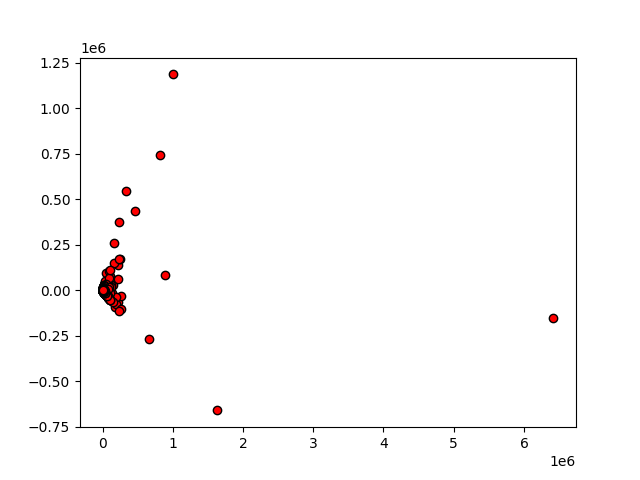

In [88]:
from sklearn.decomposition import TruncatedSVD


plt.figure();
vectors = TruncatedSVD().fit_transform(candidates_matrix)
plt.scatter(vectors[:,0], vectors[:,1], edgecolors='k', c='r');

In [92]:
from sklearn_extra.cluster import KMedoids


kmedoids = KMedoids(n_clusters=3, random_state=0).fit(candidates_matrix)